<a href="https://colab.research.google.com/github/ravichas/AMPL-Tutorial/blob/master/BSEP_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BSEP Inhibition Model Prediction
(original version of the tutorial is available from the AMPL GitHub site, https://github.com/ATOMconsortium/AMPL/tree/master/atomsci/ddm/examples/BSEP).  

This example code recreates the models published in the BSEP paper (https://arxiv.org/abs/2002.12541) and uses them for prediction using a small dataset.

You can read about BSEP gene here, 

https://en.wikipedia.org/wiki/ABCB11

and/or here,

http://useast.ensembl.org/Homo_sapiens/Gene/Summary?db=core;g=ENSG00000276582;r=CHR_HSCHR2_1_CTG7_2:168939927-168953422 

ABCB11 is a gene associated with the disease progressive familial intrahepatic cholestasis type 2 (PFIC2).PFIC2 is shown to be caused by mutations in the ABCB11 gene which increases the risk of hepatocellular carcinoma in early life.




The notebook will run through the following steps: 

1.   Clone the AMPL git repository and install the software  
2.   Use a data file, data/small_test_data.csv as input
3.   If you want to use your input data, please make sure your input data should be in CSV format that contains the following information: 
        *   Row of column headers
        *   contain a column of SMILES strings for the compounds you want to run predictions on.
        * Optional information: 
                *   A column of unique compound IDs; if none is provided, one will be generated for you
                *   A column of binary activity values, if you have measured IC50s for the input compounds: 0 if the IC50 < 100 uM, 1 if IC50 >= 100 uM.

## Here is a sample input dataset with four componds

|base_rdkit_smiles | compound_id| pIC50 |relation|active |
|------------------|------------|-------|--------|-------|
|CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C3C(=O)c4c(O)cccc4[C@@](C)(O)C3CC12"	|CHEMBL198	|3.000000	|<	|0 |
|C[C@]12C[C@H](O)[C@@]3(F)C(CCC4=CC(=O)C=C[C@@]43C)C1C[C@@H](O)[C@]2(O)C(=O)CO|CHEMBL3039453	|3.627825	|NaN	|1 |
|Nc1nc2cc(Cl)ccc2o1	|CHEMBL472566	|3.000000	|< |0|
|COc1cc([C@@H]2c3cc4c(cc3[C@@H](O[C@@H]3O[C@@H]5CO[C@@H](C)O[C@H]5[C@H](O)[C@H]3O)[C@H]3COC(=O)[C@H]23)OCO4)cc(OC)c1O	|CHEMBL44657	|3.876148	|<|	0 |



## Before you begin, make sure you close all other COLAB notebooks. 

# Change Runtime settings

## Plesae change your runtime settings to use GPU and high-memory, if you have 

## Runtime --> Change Runtime Type --> GPU

In [12]:
!date # starting time

Wed Feb 10 20:19:09 UTC 2021


## Install AMPL GPU version

The timt it will take to execute the following code chunk in COLAB
```
real	2m59.739s
user	1m48.995s
sys	0m20.614s
```

In [13]:
import requests

# Copy AMPL install script
url='https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU.sh'

downloaded_obj = requests.get(url)
with open("install_AMPL_GPU.sh", "wb") as file:
    file.write(downloaded_obj.content)


# Install and load AMPL
!chmod u+x install_AMPL_GPU.sh
!time ./install_AMPL_GPU.sh
import sys
if '/content/AMPL/lib/python3.6/site-packages' not in sys.path:
    sys.path.insert(1, '/content/AMPL/lib/python3.6/site-packages')

sys.path

--2021-02-10 20:19:09--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94235922 (90M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh.1’

Miniconda3-latest-L 100%[===================>]  89.87M   283MB/s    in 0.3s    

2021-02-10 20:19:09 (283 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh.1’ saved [94235922/94235922]

ERROR: File or directory already exists: '/content/AMPL'
If you want to update an existing installation, use the -u option.
Preparing transaction: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
Verifying transaction: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - 

['',
 '/content/AMPL/lib/python3.6/site-packages',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']

In [14]:
# There is a problem with the previously imported cffi, so delete it and 
# load it with AMPL instead
if 'cffi' in sys.modules:
  del sys.modules['cffi']

In [15]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

# import few common libraries
import json
import os
import requests

In [16]:
#
# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import pandas as pd
import numpy as np
import getpass,os
import io

In [17]:
%cd /content/github/AMPL/atomsci/ddm/examples/BSEP

/content/github/AMPL/atomsci/ddm/examples/BSEP


In [18]:
%%bash 
mv predict_bsep_inhibition.py predict_bsep_inhibition.py.orig
wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/supp_codes/predict_bsep_inhibition.py

--2021-02-10 20:19:41--  https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/supp_codes/predict_bsep_inhibition.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7432 (7.3K) [text/plain]
Saving to: ‘predict_bsep_inhibition.py’

     0K .......                                               100% 51.5M=0s

2021-02-10 20:19:41 (51.5 MB/s) - ‘predict_bsep_inhibition.py’ saved [7432/7432]



In [19]:
!ls data

ChEMBL25_BSEP_curated_data.csv	      README.md
ChEMBL25_BSEP_test_data.csv	      small_test_data.csv
morgan_warner_combined_bsep_data.csv


In [20]:
df_test_data = pd.read_csv("data/small_test_data.csv")

In [21]:
df_test_data['base_rdkit_smiles'].values[0:4]

array(['CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C3C(=O)c4c(O)cccc4[C@@](C)(O)C3CC12',
       'C[C@]12C[C@H](O)[C@@]3(F)C(CCC4=CC(=O)C=C[C@@]43C)C1C[C@@H](O)[C@]2(O)C(=O)CO',
       'Nc1nc2cc(Cl)ccc2o1',
       'COc1cc([C@@H]2c3cc4c(cc3[C@@H](O[C@@H]3O[C@@H]5CO[C@@H](C)O[C@H]5[C@H](O)[C@H]3O)[C@H]3COC(=O)[C@H]23)OCO4)cc(OC)c1O'],
      dtype=object)

Traceback (most recent call last):
  File "/content/AMPL/lib/python3.6/site-packages/rdkit/Chem/PandasTools.py", line 130, in <module>
    if 'display.width' in pd.core.config._registered_options:
AttributeError: module 'pandas.core' has no attribute 'config'


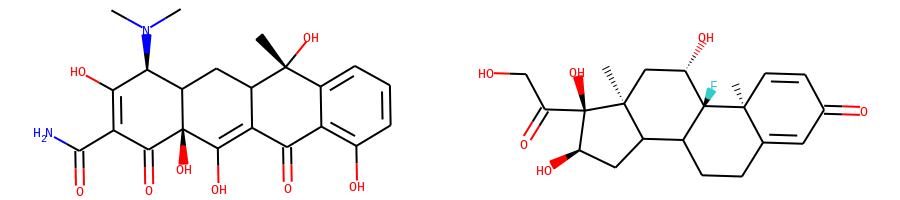

In [22]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor

#Needed to show molecules
from rdkit.Chem.Draw import IPythonConsole 

from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions 
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.molSize = (450,400)
mol0 = df_test_data['base_rdkit_smiles'][0]
mol0_m = Chem.MolFromSmiles(mol0)
# rdDepictor.SetPreferCoordGen(False)
rdDepictor.Compute2DCoords(mol0_m)

mol1 = df_test_data['base_rdkit_smiles'][1]
mol1_m = Chem.MolFromSmiles(mol1)
# rdDepictor.SetPreferCoordGen(False)
rdDepictor.Compute2DCoords(mol1_m)


molecules = [ mol0_m, mol1_m ]
Draw.MolsToGridImage(molecules, molsPerRow = 2, subImgSize=(450, 200))

In [23]:
%%bash
chmod +x predict_bsep_inhibition.py

In [24]:
%%bash
./predict_bsep_inhibition.py -i data/small_test_data.csv -o small_test_output.csv --id_col compound_id \
--smiles_col base_rdkit_smiles --activity_col active

Standardizing SMILES strings for 19 compounds.
Reading descriptor spec table from /content/AMPL/lib/python3.6/site-packages/atomsci/ddm/data/descriptor_sets_sources_by_descr_type.csv
Featurization = DescriptorFeaturization with mordred_filtered descriptors
/content/AMPL/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
number of features: 1555
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
Wrote predictions to file small_test_output.csv
Performance metrics:

13 out of 19 predictions correct.
Accuracy: 0.684
Precision: 0.400
Recall: 0.400
NPV: 0.786
ROC AUC: 0.743
PRC AUC: 0.549
Matthews correlation coefficient: 0.186
Confusion matrix:
		predicted activity
actual
activity	0	1

   0		11	3
   1		3	2


/content/AMPL/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/content/AMPL/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
2021-02-10 20:19:44,539 ['time_built', 'dataset_metadata', 'training_metrics', 'time_generated', 'best_epoch'] are not part of the accepted list of parameters and will be ignored
2021-02-10 20:19:44.545099: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that t

## Output

The output will be a CSV file with the following columns:

Compound ID

*   **compound ID**: SMILES strings as input
*   standardized_smiles: 
*   **active actual**: Input activity
*   **active prob**: Predicted probabilities, 
*   **active pred**: Predicted activity. In this case for each compounds to be a BSEP inhibitor (1) or not (0)

In [25]:
df_output = pd.read_csv("small_test_output.csv")

In [27]:
df_output.head(5)

,compound_id,standardized_smiles,active_actual,active_prob,active_pred,base_rdkit_smiles
0,CHEMBL1200777,N[C@H](Cc1cc(I)c(Oc2cc(I)c(O)c(I)c2)c(I)c1)C(=...,1,9.999999e-01,1,N[C@H](Cc1cc(I)c(Oc2cc(I)c(O)c(I)c2)c(I)c1)C(=...
1,CHEMBL1200820,CCN1CCN(C(=O)N[C@@H](C(=O)N[C@@H]2C(=O)N3[C@@H...,0,9.768197e-01,1,CCN1CCN(C(=O)N[C@@H](C(=O)N[C@@H]2C(=O)N3[C@@H...
2,CHEMBL1201203,CN1[C@H]2CC[C@@H]1C[C@H](OC(c1ccccc1)c1ccccc1)C2,1,4.675714e-14,0,CN1[C@H]2CC[C@@H]1C[C@H](OC(c1ccccc1)c1ccccc1)C2
3,CHEMBL1231530,O=C(O)CCNC(=O)c1ccccc1,0,7.009206e-36,0,O=C(O)CCNC(=O)c1ccccc1
4,CHEMBL15677,O=C(O)Cc1ccccc1Oc1ccc(Cl)cc1Cl,1,4.339569e-02,0,O=C(O)Cc1ccccc1Oc1ccc(Cl)cc1Cl
